Loading AI-Dev dataset...
✅ Dataset loaded: 932791 PRs
Available columns: ['id', 'number', 'title', 'user', 'user_id', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_url', 'repo_id', 'html_url', 'body', 'agent']
✅ PRs with merge/close info: 859927
✅ Total PRs with Copilot config: 1603
✅ Sampled 300 Copilot PRs for analysis.

===== RQ1: Context Characteristics =====
Average lines changed per PR (approx.): 33.10
Bug/fix keywords present in 72.7% of PRs

===== RQ2: Accepted vs Rejected Fixes =====
       n_lines_changed  has_bug_kw
label                             
0            46.314815    0.888889
1            30.203252    0.691057


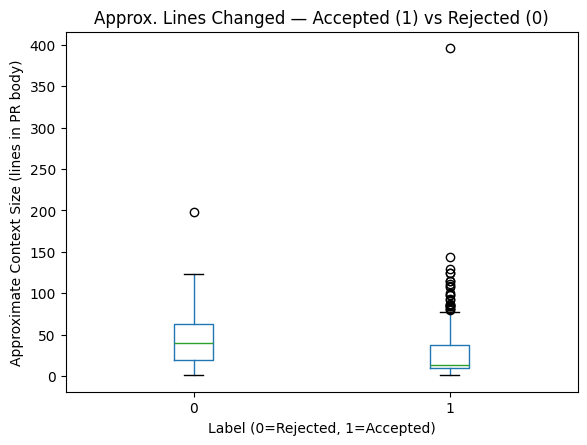

In [33]:
# ============================================================
# 🔹 AI-Dev Dataset Analysis (Copilot-Focused, Compatible Version)
# ============================================================
# Research Questions:
# RQ1. What characterizes the contexts that AI-agents (Copilot) use for fixing bugs?
# RQ2. How different are accepted and rejected fixes in terms of these characteristics?
# ============================================================

from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Load dataset from Hugging Face
print("Loading AI-Dev dataset...")
ds = load_dataset("hao-li/AIDev", split="train")

# Convert to DataFrame for analysis
df = pd.DataFrame(ds)
print("✅ Dataset loaded:", len(df), "PRs")
print("Available columns:", df.columns.tolist())

# 2️⃣ Keep only available columns
df = df[[
    "id", "number", "title", "user", "state", "created_at", "closed_at",
    "merged_at", "repo_url", "html_url", "body", "agent"
]].copy()

# 3️⃣ Label PRs (accepted if merged, rejected if closed)
def label_pr(row):
    if pd.notnull(row["merged_at"]):
        return 1  # accepted
    elif str(row["state"]).lower() == "closed":
        return 0  # rejected
    else:
        return None

df["label"] = df.apply(label_pr, axis=1)
valid_df = df.dropna(subset=["label"]).copy()
valid_df["label"] = valid_df["label"].astype(int)
print("✅ PRs with merge/close info:", len(valid_df))

# 4️⃣ Derive context features
# Approximate "lines changed" using length of PR body (proxy for context size)
valid_df["n_lines_changed"] = valid_df["body"].apply(lambda x: len(str(x).splitlines()))

# Detect bug/fix keywords
bug_keywords = ["bug", "fix", "error", "issue", "debug", "patch", "fault"]
valid_df["has_bug_kw"] = valid_df["title"].fillna("").str.lower().apply(
    lambda t: int(any(kw in t for kw in bug_keywords))
) | valid_df["body"].fillna("").str.lower().apply(
    lambda t: int(any(kw in t for kw in bug_keywords))
)

# 5️⃣ Detect Copilot-related PRs
def has_copilot_config(x):
    text = str(x).lower()
    return int(any(k in text for k in [
        ".github/copilot", "copilot", "github-copilot", "copilotchat", "copilotx"
    ]))

valid_df["has_copilot_config"] = valid_df["repo_url"].apply(has_copilot_config)
print("✅ Total PRs with Copilot config:", valid_df["has_copilot_config"].sum())

# 6️⃣ Filter for Copilot-related PRs
copilot_df = valid_df[valid_df["has_copilot_config"] == 1].copy()
if len(copilot_df) > 300:
    copilot_df = copilot_df.sample(300, random_state=42)
    print("✅ Sampled 300 Copilot PRs for analysis.")
else:
    print("✅ Using all", len(copilot_df), "Copilot PRs for analysis.")

# 7️⃣ RQ1: Describe Copilot PR contexts
rq1_lines_mean = copilot_df["n_lines_changed"].mean()
rq1_bug_kw_rate = copilot_df["has_bug_kw"].mean() * 100

print("\n===== RQ1: Context Characteristics =====")
print(f"Average lines changed per PR (approx.): {rq1_lines_mean:.2f}")
print(f"Bug/fix keywords present in {rq1_bug_kw_rate:.1f}% of PRs")

# 8️⃣ RQ2: Compare Accepted vs Rejected Fixes
rq2_group = copilot_df.groupby("label")[["n_lines_changed", "has_bug_kw"]].mean()
print("\n===== RQ2: Accepted vs Rejected Fixes =====")
print(rq2_group)

# 9️⃣ Visualization (optional)
copilot_df.boxplot(column="n_lines_changed", by="label", grid=False)
plt.title("Approx. Lines Changed — Accepted (1) vs Rejected (0)")
plt.suptitle("")
plt.xlabel("Label (0=Rejected, 1=Accepted)")
plt.ylabel("Approximate Context Size (lines in PR body)")
plt.show()
